C:\UserData\takuyai\Miniconda3\envs\lith_nlp\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


41 Unique LithCodes that are not UNKN or numeric
['GRVL' 'CLAY' 'CRSE' 'SHLE' 'BSLT' 'ROCK' 'SAND' 'SOIL' 'GRNT' 'SASH'
 'CGLM' 'SDSN' 'TPSL' 'BLBN' 'COAL' 'SILT' 'LMSN' 'ALVM' 'QRTZ' 'SDCY'
 'LOAM' 'BLDR' 'SLTE' 'SLCY' 'BNST' 'VLCC' 'SLSN' 'BRBN' 'GRBN' 'MDSN'
 'WB' 'TUFF' 'BDRK' 'SNDY' 'SDMN' 'CVTY' 'CLBD' 'FILL' 'DLMT' 'WODY'
 'FINE']
Attempting to fill in 99 unknown MajorLithCode based on provided descriptions


100%|█████████████████████████████████████████████████████████████████| 99/99 [00:30<00:00,  3.23it/s]


After clean up 40 unique LithCodes that are not UNKN or numeric
['GRVL' 'CLAY' 'CRSE' 'SHLE' 'BSLT' 'ROCK' 'SAND' 'SOIL' 'TPSL' 'GRNT'
 'SASH' 'CGLM' 'SDSN' 'COAL' 'SILT' 'LMSN' 'ALVM' 'QRTZ' 'SDCY' 'LOAM'
 'BLDR' 'SLTE' 'SLCY' 'VLCC' 'SLSN' 'BRBN' 'GRBN' 'MDSN' 'WB' 'TUFF'
 'BDRK' 'SNDY' 'SDMN' 'CVTY' 'CLBD' 'FILL' 'DLMT' 'WODY' 'BNST' 'FINE']
(1000,) (1000,)
Number of entries 1000
Dictionary(136 unique tokens: ['bear', 'cement', 'gravel', 'water', 'clay']...)


notebook_setup.ipynb:8: UserWarning: WARNING - Filtering to unique combinations, which may not be desirable in the future!
  "source": [


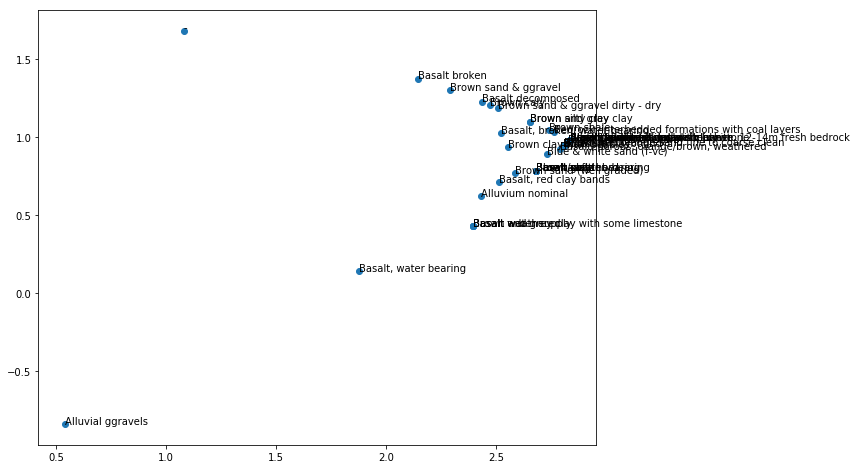

In [1]:
%run notebook_setup.ipynb

## Using a word matrix, PCA, and Affinity Propagation

Some useful links:
* http://www.psi.toronto.edu/affinitypropagation/faq.html
* https://stackoverflow.com/questions/47153203/cluster-word2vec-vectors-using-affinity-propagation-in-python-sklearn
* https://stackoverflow.com/questions/35494458/affinity-propagation-in-python
* http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/
* https://towardsdatascience.com/introduction-to-text-representation-and-similarity-b5dd3fd71737

AffinityPropagation can use similarity (rather than distances).

In [2]:
lith_code_desc.head()

,Description,count
0,-,1
1,Alluvial ggravels,1
2,Alluvium,1
3,Alluvium nominal,1
4,Alluvium water supply,1


In [24]:
lith_code_desc, all_words, word_map = merge_similar_words(lith_code_desc, stopwords, target_columns)

In [5]:
word_matrix = pd.DataFrame({w: [0, ] * len(lith_code_desc.index) for w in all_words}, index=lith_code_desc.index)

In [6]:
lith_code_desc.loc[lith_code_desc.tokens.str.len() == 0, :].head(10)

,Description,count,tokens
0,-,1,[]
325,Red,1,[]


In [7]:
len(lith_code_desc.loc[lith_code_desc.tokens.str.len() == 0, :])

2

In [23]:
lith_code_desc.head(10)

,Description,count,tokens
0,-,1,[]
1,Alluvial ggravels,1,"[alluvi, gravel]"
2,Alluvium,1,[alluvi]
3,Alluvium nominal,1,"[alluvi, min]"
4,Alluvium water supply,1,"[alluvi, water, suppli]"
5,As above.,1,[abov]
6,Basalt,18,[basalt]
7,Basalt - water bearing,1,"[basalt, water, bear]"
8,Basalt broken,1,"[basalt, broken]"
9,Basalt decomposed,3,"[basalt, compos]"


In [9]:
tmp = get_nouns(tokenize_and_stem('Fine to coarse brown sand', []))
tmp = [w for w in tmp if w not in stopwords]
tmp

['sand']

In [10]:
for row in lith_code_desc.itertuples():
    tmp = row.tokens
    for w in tmp:
        if w in all_words:
            word_matrix.at[row.Index, w] = 1
    # End for
# End for

In [22]:
lith_code_desc.head()

,Description,count,tokens
0,-,1,[]
1,Alluvial ggravels,1,"[alluvi, gravel]"
2,Alluvium,1,[alluvi]
3,Alluvium nominal,1,"[alluvi, min]"
4,Alluvium water supply,1,"[alluvi, water, suppli]"


In [12]:
len(word_matrix.loc[word_matrix.granit == 1, :])

13

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=5)  # , whiten=True
compressed = pca.fit_transform(word_matrix.values)

In [14]:
word_matrix.values.shape

(560, 214)

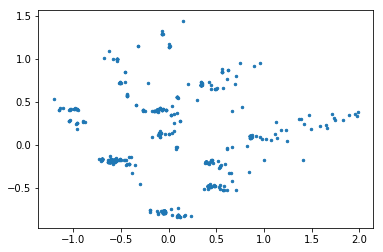

In [15]:
plt.scatter(compressed[:, 0], compressed[:, 1], s=6);

In [16]:
compressed.shape

(560, 2)

In [17]:
import random
random.seed(1)  # set known seed to replicate results

# Naive Monte Carlo search
success = False
for i in range(100):
    damp_factor = random.uniform(0.5, 0.99)
    
    ap_model = sklearn.cluster.AffinityPropagation(damping=damp_factor)  # , preference=-np.median(compressed)
    ap_model.fit(compressed)
    
    if 45 <= len(ap_model.cluster_centers_indices_) <= 65:
        cluster_centers_idx = ap_model.cluster_centers_indices_
        labels = ap_model.labels_
        unique_labels = np.unique(labels)
        n_clusters_ = len(cluster_centers_idx)
        print("Num clusters:", n_clusters_, "with damping factor of", damp_factor)
        success = True
        break
    # End if
# End for

if not success:
    print("Could not find suitable damping factor")
    damp_factor = 0.6  # fall back damping factor

Num clusters: 49 with damping factor of 0.6249838226123167


In [18]:
# from sklearn.metrics.pairwise import cosine_similarity

# Convert to cosine similarity matrix
# cos_sim = cosine_similarity(compressed)
# , affinity="precomputed"
ap_model = sklearn.cluster.AffinityPropagation(damping=damp_factor)  # , preference=-np.median(compressed)
ap_model.fit(compressed)

cluster_centers_idx = ap_model.cluster_centers_indices_
labels = ap_model.labels_
unique_labels = np.unique(labels)
n_clusters_ = len(cluster_centers_idx)
print("Num clusters:", n_clusters_)

Num clusters: 49


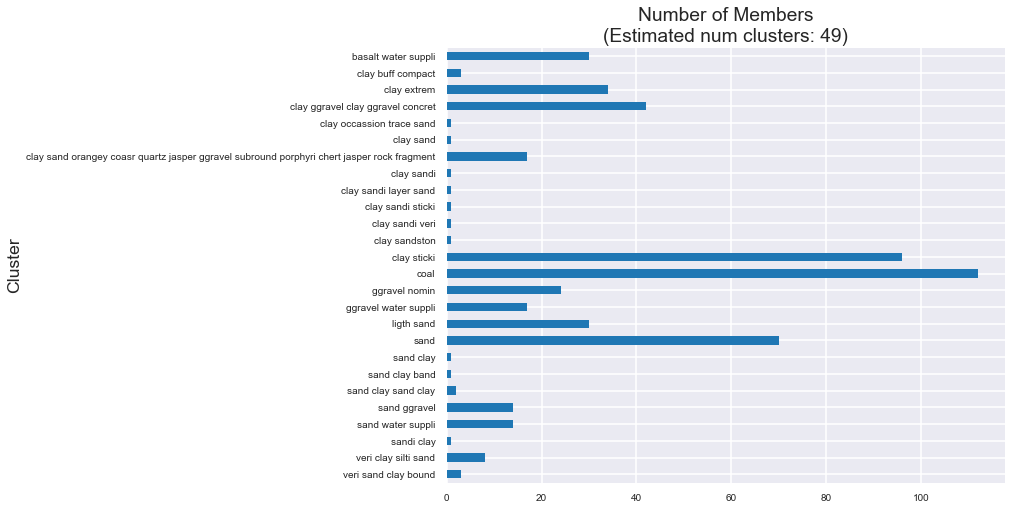

In [19]:
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

cluster_data = {}
for k in range(n_clusters_):
    class_members = labels == k
    
    cluster_size = len(class_members[class_members == True])
    exemplar = lith_code_desc.Description[cluster_centers_idx[k]]
    exemplar = " ".join(get_nouns(tokenize_and_stem(exemplar, stopwords)))
    cluster_data[exemplar] = cluster_size
# End for

fig, ax = plt.subplots(figsize=(10,8))
clustered_info = pd.DataFrame.from_dict(cluster_data, orient='index')
clustered_info.index.name = 'Cluster'
clustered_info.columns = ['Members']
clustered_info.sort_index(ascending=False, inplace=True)
clustered_info.plot(kind='barh', fontsize=10, title=f'Number of Members\n(Estimated num clusters: {n_clusters_})', 
                    legend=False, ax=ax);

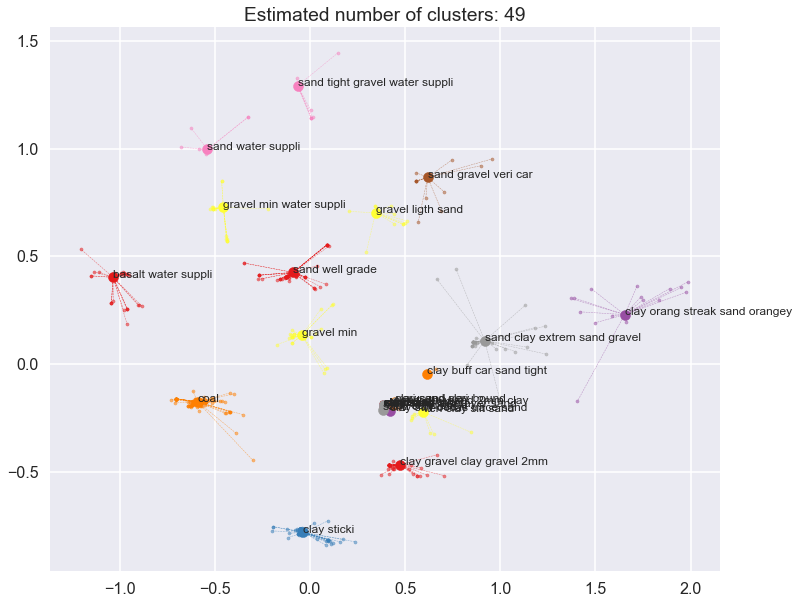

In [20]:
fig, ax = plt.subplots(figsize=(12,10))

cm = plt.get_cmap('Set1')
colors = [cm(1.0*i/n_clusters_) for i in range(n_clusters_)]

lith_desc = lith_code_desc.tokens

count = 0
# for each cluster get all members and plot with same color
for cluster_idx, color in zip(range(n_clusters_), colors):
    in_cluster = labels == cluster_idx
    cluster_set = compressed[in_cluster]
    
    cluster_row = cluster_centers_idx[cluster_idx]
    cluster_center = compressed[cluster_row]
    
    exemplar = " ".join(tokenize_and_stem(" ".join(str(i) for i in lith_desc[cluster_row]), stopwords))
    
    # Plot cluster exemplar
    ax.scatter(cluster_center[0], cluster_center[1], marker='o', c=color, s=100)
    ax.annotate(" ".join(exemplar.split()[:5]), (cluster_center[0], cluster_center[1]), 
                alpha=1, fontsize=12)
    
    for i, txt in enumerate(lith_desc[in_cluster]):
        if txt == exemplar:
            continue
            
        x, y = cluster_set[i]
        
        # Plot cluster member
        ax.scatter(x, y, marker='o', c=color, alpha=0.5, s=10)
        
        # Plot line between cluster exemplar and member
        plt.plot([cluster_center[0], x], [cluster_center[1], y], c=color, 
                 linestyle='--', linewidth=0.5, alpha=0.6)
        
        # Add text annotation
        # ax.annotate(" ".join(txt.split()[0:3]), (x, y), alpha=0.1)
    # End for
    
# End for

plt.title(f"Estimated number of clusters: {n_clusters_}");

In [21]:
# Write out results to csv
res = {}

lith_desc = lith_code_desc.Description
for cluster_id in unique_labels:
    exemplar = lith_desc[cluster_centers_idx[cluster_id]]
    exemplar = " ".join(tokenize_and_stem(exemplar, stopwords)) # for i in exemplar
    
    cluster = np.unique(lith_desc[np.nonzero(labels == cluster_id)[0]])
    res[str(cluster_id)+'_'+exemplar] = " | ".join(cluster)
# End for

res_df = pd.DataFrame([i for i in res.values()], index=res.keys(), columns=["Matches"])
res_df.index.name = "Exemplar"

try:
    res_df.to_csv("ap2_output.csv", index=True)
except PermissionError:
    raise PermissionError("ERROR OCCURRED - csv file is probably open in Excel. Close Excel and try again.")
# End try

assert len(unique_labels) == len(res_df.index), "Number of clusters do not match outputted cluster exemplars!"